# CS 20 : TensorFlow for Deep Learning Research
## Lecture 07 : ConvNet in TensorFlow
Specification of SimpleCNN is same that of [Lec07_ConvNet mnist by low-level.ipynb](https://nbviewer.jupyter.org/github/aisolab/CS20/blob/master/Lec07_ConvNet%20in%20Tensorflow/Lec07_ConvNet%20mnist%20by%20low-level.ipynb)
### ConvNet mnist by high-level
- Creating the **data pipeline** with `tf.data`
- Using `tf.contrib.slim`, alias `slim`
- Creating the model as **Class** with `slim`
- Training the model with **Drop out** technique by `slim.dropout`
- Using tensorboard

### Setup

In [1]:
from __future__ import absolute_import, division, print_function
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

slim = tf.contrib.slim
print(tf.__version__)

1.12.0


### Load and Pre-process data

In [2]:
(x_train, y_train), (x_tst, y_tst) = tf.keras.datasets.mnist.load_data()
x_train = x_train  / 255
x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32)
x_tst = x_tst / 255
x_tst = x_tst.reshape(-1, 28, 28, 1).astype(np.float32)

In [3]:
tr_indices = np.random.choice(range(x_train.shape[0]), size = 55000, replace = False)

x_tr = x_train[tr_indices]
y_tr = y_train[tr_indices].astype(np.int32)

x_val = np.delete(arr = x_train, obj = tr_indices, axis = 0)
y_val = np.delete(arr = y_train, obj = tr_indices, axis = 0).astype(np.int32)

print(x_tr.shape, y_tr.shape)
print(x_val.shape, y_val.shape)

(55000, 28, 28, 1) (55000,)
(5000, 28, 28, 1) (5000,)


### Define SimpleCNN class by high-level api (slim)

In [4]:
class SimpleCNN:
    def __init__(self, X, y, n_of_classes):
        
        self._X = X
        self._y = y
        self._is_training = tf.placeholder(dtype = tf.bool)

        with slim.arg_scope([slim.conv2d, slim.fully_connected], activation_fn = tf.nn.relu,
                            weights_initializer = tf.truncated_normal_initializer(),
                            biases_initializer = tf.truncated_normal_initializer()):
            with slim.arg_scope([slim.conv2d], kernel_size = [5, 5], stride = 1, padding = 'SAME'):
                with slim.arg_scope([slim.max_pool2d], kernel_size = [2, 2], stride = 2, padding = 'SAME'):
                    
                    conv1 = slim.conv2d(inputs = self._X, num_outputs = 32, scope = 'conv1')
                    pool1 = slim.max_pool2d(inputs = conv1, scope = 'pool1')
                    conv2 = slim.conv2d(inputs = pool1, num_outputs = 64, scope = 'conv2')
                    pool2 = slim.max_pool2d(inputs = conv2, scope = 'pool2')
                    flattened = slim.flatten(inputs = pool2)
                    fc = slim.fully_connected(inputs = flattened, num_outputs = 1024, scope = 'fc1')
                    dropped = slim.dropout(inputs = fc, keep_prob = .5, is_training = self._is_training)
                    self._score = slim.fully_connected(inputs = dropped, num_outputs = n_of_classes,
                                                       activation_fn = None, scope = 'score')
                    self.ce_loss = self._loss(labels = self._y, logits = self._score, scope = 'ce_loss')
        
        with tf.variable_scope('prediction'):
            self._prediction = tf.argmax(input = self._score, axis = -1)
        
    def _loss(self, labels, logits, scope):
        with tf.variable_scope(scope):
            ce_loss = tf.losses.sparse_softmax_cross_entropy(labels = labels, logits = logits)f.reduce_mean(
            return ce_loss
        
    def predict(self, sess, x_data, is_training = True):
        feed_prediction = {self._X : x_data, self._is_training : is_training}
        return sess.run(self._prediction, feed_dict = feed_prediction)

### Create a model of SimpleCNN

In [5]:
# hyper-parameter
lr = .01
epochs = 30
batch_size = 100
total_step = int(x_tr.shape[0] / batch_size)
print(total_step)

550


In [6]:
## create input pipeline with tf.data
# for train
tr_dataset = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
tr_dataset = tr_dataset.shuffle(buffer_size = 10000)
tr_dataset = tr_dataset.batch(batch_size = batch_size)
tr_iterator = tr_dataset.make_initializable_iterator()
print(tr_dataset)

# for validation
val_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_dataset = val_dataset.batch(batch_size = batch_size)
val_iterator = val_dataset.make_initializable_iterator()
print(val_dataset)

<BatchDataset shapes: ((?, 28, 28, 1), (?,)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((?, 28, 28, 1), (?,)), types: (tf.float32, tf.int32)>


In [7]:
## define Iterator
# tf.data.Iterator.from_string_handle의 output_shapes는 default = None이지만 꼭 값을 넣는 게 좋음
handle = tf.placeholder(dtype = tf.string)
iterator = tf.data.Iterator.from_string_handle(string_handle = handle,
                                               output_types = tr_iterator.output_types,
                                               output_shapes = tr_iterator.output_shapes)

x_data, y_data = iterator.get_next()

In [8]:
## connecting data pipeline with model
cnn = SimpleCNN(X = x_data, y = y_data, n_of_classes = 10)

### Create training op and train model

In [9]:
## create training op
opt = tf.train.AdamOptimizer(learning_rate = lr)

# equal to 'var_list = None'
training_op = opt.minimize(loss = cnn.ce_loss)

#for tensorboard
loss_summ = tf.summary.scalar(name = 'loss', tensor = cnn.ce_loss)

In [10]:
## for tensorboard
tr_writer = tf.summary.FileWriter('../graphs/lecture07/convnet_mnist_high/train/', graph = tf.get_default_graph())
val_writer = tf.summary.FileWriter('../graphs/lecture07/convnet_mnist_high/val/', graph = tf.get_default_graph())
saver = tf.train.Saver()

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
tr_handle, val_handle = sess.run(fetches = [tr_iterator.string_handle(), val_iterator.string_handle()])

tr_loss_hist = []
val_loss_hist = []

for epoch in range(epochs):

    avg_tr_loss = 0
    avg_val_loss = 0
    tr_step = 0
    val_step = 0

    # for mini-batch training
    sess.run(tr_iterator.initializer)    
    try:
        while True:
            _, tr_loss, tr_loss_summ = sess.run(fetches = [training_op, cnn.ce_loss, loss_summ],
                                               feed_dict = {handle : tr_handle, cnn._is_training : True})
            avg_tr_loss += tr_loss
            tr_step += 1
            
    except tf.errors.OutOfRangeError:
        pass

    # for validation
    sess.run(val_iterator.initializer)
    try:
        while True:
            val_loss, val_loss_summ = sess.run(fetches = [cnn.ce_loss, loss_summ],
                                               feed_dict = {handle : val_handle, cnn._is_training : False})
            avg_val_loss += val_loss
            val_step += 1
    
    except tf.errors.OutOfRangeError:
        pass

    avg_tr_loss /= tr_step
    avg_val_loss /= val_step
    tr_writer.add_summary(summary = tr_loss_summ, global_step = epoch + 1)
    val_writer.add_summary(summary = val_loss_summ, global_step = epoch + 1)
    tr_loss_hist.append(avg_tr_loss)
    val_loss_hist.append(avg_val_loss)
    
    if (epoch + 1) % 5 == 0:
        print('epoch : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch + 1, avg_tr_loss, avg_val_loss))

tr_writer.close()
val_writer.close()
saver.save(sess = sess, save_path = '../graphs/lecture07/convnet_mnist_high/cnn/')

epoch :   5, tr_loss : 7.688, val_loss : 9.466
epoch :  10, tr_loss : 3.639, val_loss : 3.486
epoch :  15, tr_loss : 1.158, val_loss : 1.244
epoch :  20, tr_loss : 0.483, val_loss : 0.416
epoch :  25, tr_loss : 0.467, val_loss : 0.459
epoch :  30, tr_loss : 0.455, val_loss : 0.542


'../graphs/lecture07/convnet_mnist_high/cnn/'

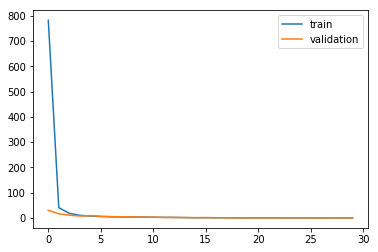

In [12]:
plt.plot(tr_loss_hist, label = 'train')
plt.plot(val_loss_hist, label = 'validation')
plt.legend()

In [13]:
yhat = cnn.predict(sess = sess, x_data = x_tst)
print('test acc: {:.2%}'.format(np.mean(yhat == y_tst)))

test acc: 94.63%
